# Hugging Face and Sagemaker
### Fine-tuning DistilBERT with Amazon dataset

# Introduction

In this demo, you will use the Hugging Faces `transformers` and `datasets` library with Amazon SageMaker to fine-tune a pre-trained transformer on binary text classification. In particular, you will use the pre-trained DistilBERT model with the Amazon Reviews Polarity dataset.
You will then deploy the resulting model for inference using SageMaker Endpoint.

## The model

You'll be using an offshoot of [BERT](https://arxiv.org/abs/1810.04805) called [DistilBERT](https://arxiv.org/abs/1910.01108) that is smaller, and so faster and cheaper for both training and inference. A pre-trained model is available in the [`transformers`](https://huggingface.co/transformers/) library from [Hugging Face](https://huggingface.co/).

## The data

The [Amazon Reviews Polarity dataset](https://github.com/dsk78/Text-Classification---Amazon-Reviews-Polarity) consists of reviews from Amazon. The data span a period of 18 years, including ~35 million reviews up to March 2013. Reviews include product and user information, ratings, and a plaintext review. It's avalaible under the [`amazon_polarity`](https://huggingface.co/datasets/amazon_polarity) dataset on [Hugging Face](https://huggingface.co/).

# Setup

## Dependecies

In [44]:
!pip install -qq "sagemaker>=2.48.0" --upgrade
!pip install -qq torch==1.7.1 --upgrade
!pip install -qq sagemaker-huggingface-inference-toolkit 
!pip install -qq transformers==4.6.1 "datasets[s3]"
!pip install -qq watermark 
!pip install -qq "seaborn>=0.11.0"

In [42]:
%reload_ext watermark
%watermark -v -p sagemaker,numpy,pandas,torch,transformers,datasets,seaborn

CPython 3.6.13
IPython 7.16.1

sagemaker 2.48.0
numpy 1.19.5
pandas 1.1.5
torch 1.7.1
transformers 4.6.1
datasets 1.9.0
seaborn 0.11.1


## Development environment 

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [8]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs
import sagemaker.huggingface
from sagemaker.huggingface import HuggingFace
import transformers
from transformers import AutoTokenizer
from datasets import load_dataset


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from textwrap import wrap

import boto3
import pprint
import time

In [9]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 17, 8

## Set up SageMaker session and bucket

In [10]:
sess = sagemaker.Session()
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::523588066826:role/service-role/AmazonSageMaker-ExecutionRole-20200723T165478
sagemaker bucket: sagemaker-us-west-2-523588066826
sagemaker session region: us-west-2


# Data preparation

The data preparation is straightforward as you're using the `datasets` library to download and preprocess the `
amazon_polarity` dataset directly from Hugging face. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job.

In [11]:
dataset_name = 'amazon_polarity'

train_dataset, test_dataset = load_dataset(dataset_name, split=['train', 'test'])
train_dataset = train_dataset.shuffle().select(range(8000)) # limiting the dataset size to speed up the training during the demo
test_dataset = test_dataset.shuffle().select(range(1600))

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/860 [00:00<?, ?B/s]

Reusing dataset amazon_polarity (/home/ec2-user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/ac31acedf6cda6bc2aa50d448f48bbad69a3dd8efc607d2ff1a9e65c2476b4c1)


In [12]:
print(train_dataset.column_names)

['content', 'label', 'title']


In [13]:
train_dataset[0]

{'content': 'Little Slow on Review.. I only get to read at Dr Appts and other type breaks in day.Worth the read and I can understand mind set of why book is popular in war zones.I would suggest it to anyone that enjoys military reading..',
 'label': 1,
 'title': 'Soild Number 1 Book In Iraq and Afganastan'}

The dataset is already well balanced

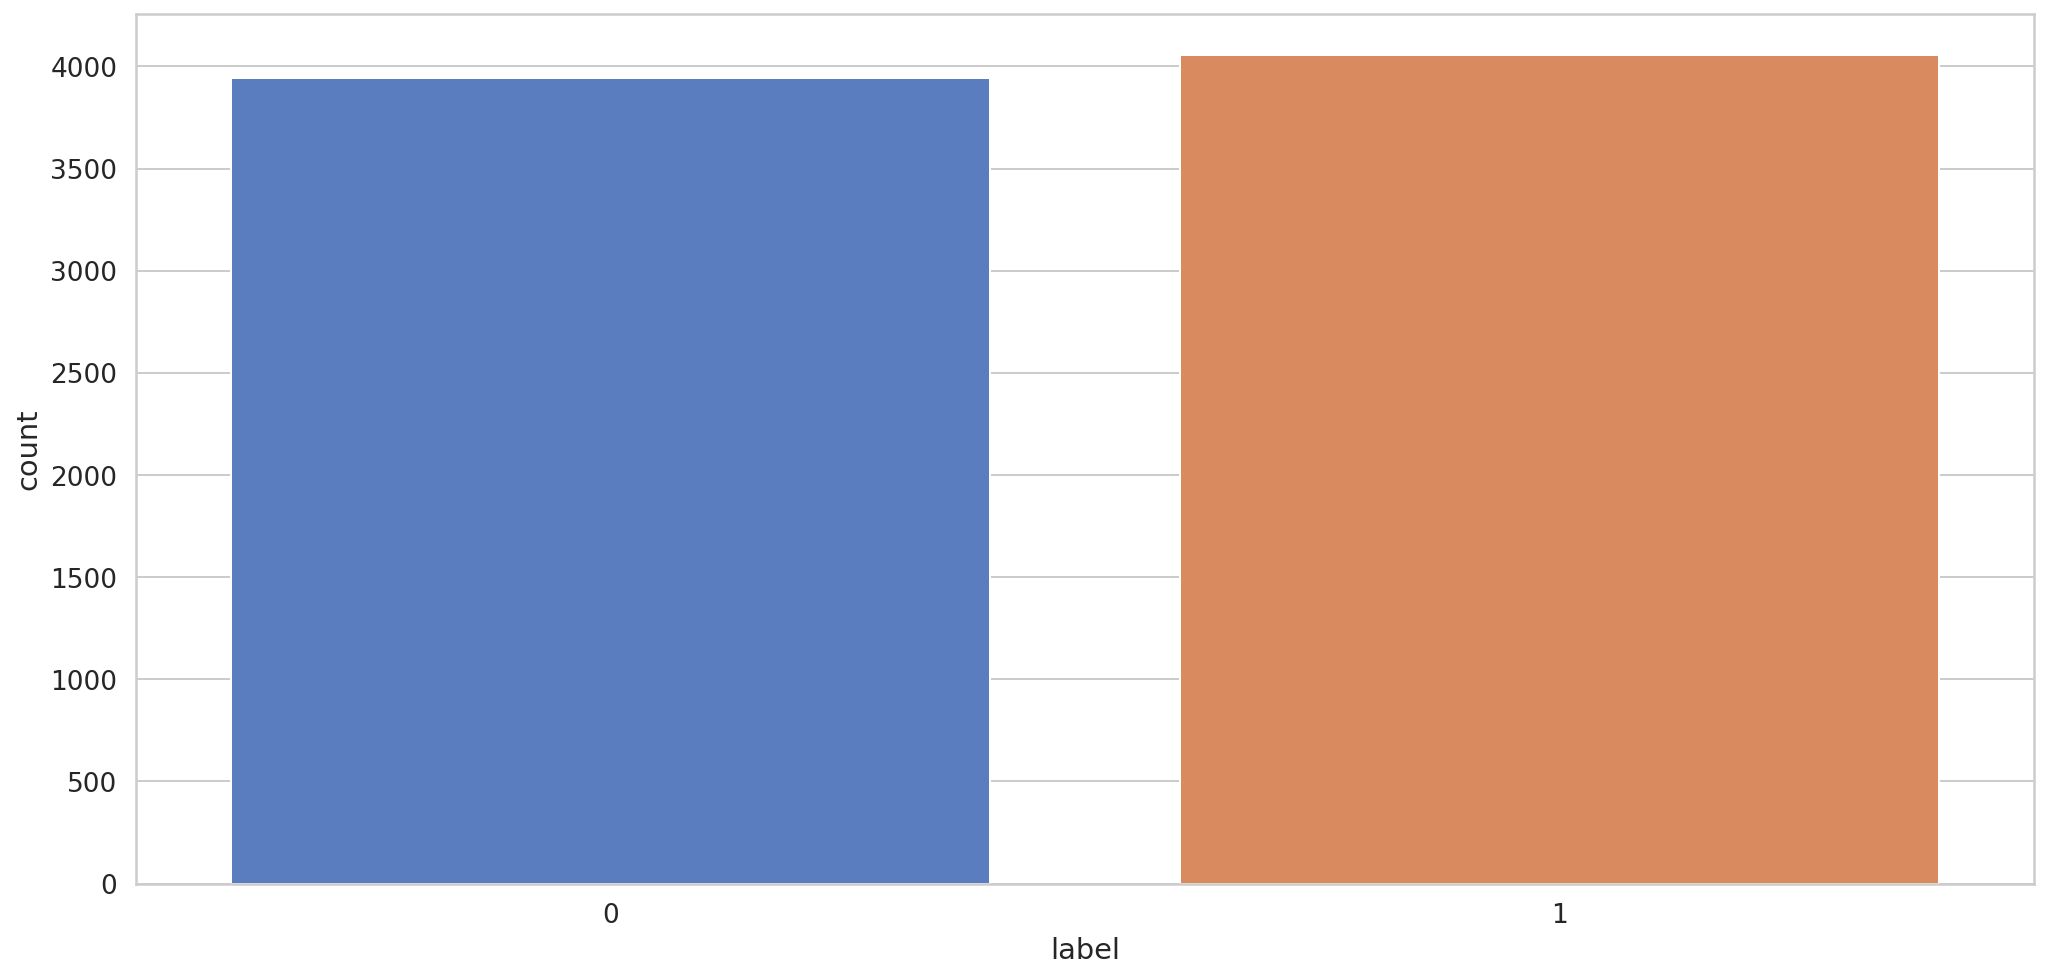

In [14]:
sns.countplot(x=train_dataset['label'])
plt.xlabel('label');

## Preparing the dataset to be used with PyTorch
You now need to convert the dataset for training. This means using a tokenizer and getting the PyTorch tensors. Hugging Face provides an [`AutoTokenizer`](https://huggingface.co/transformers/model_doc/auto.html#autotokenizer)

This downloads the tokenizer:

In [15]:
tokenizer_name = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

And this tokenize our training and testing datasets and then set them to the PyTorch format:

In [16]:
# Helper function to get the content to tokenize
def tokenize(batch):
    return tokenizer(batch['content'], padding='max_length', truncation=True)

# Tokenize
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# Set the format to PyTorch
train_dataset.rename_column_("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.rename_column_("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: rename_column_ is deprecated and will be removed in the next major version of datasets. Use Dataset.rename_column instead.


## Uploading the data to S3

Now that the data as been processed you can upload it to S3 for training

In [17]:
import botocore
from datasets.filesystems import S3FileSystem

# Upload to S3
s3 = S3FileSystem()
s3_prefix = f'samples/datasets/{dataset_name}'
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)

print(f'Uploaded training data to {training_input_path}')
print(f'Uploaded testing data to {test_input_path}')

Uploaded training data to s3://sagemaker-us-west-2-523588066826/samples/datasets/amazon_polarity/train
Uploaded testing data to s3://sagemaker-us-west-2-523588066826/samples/datasets/amazon_polarity/test


# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job you need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator you define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in.
```python
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.6.1',
                            pytorch_version='1.7.1',
                            py_version='py36',
                            hyperparameters = hyperparameters)
```
When you create a SageMaker training job, SageMaker takes care of starting and managing all the required compute instances with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container local storage at `/opt/ml/input/data`. Then, it starts the training job by running. 
```python
/opt/conda/bin/python train.py --epochs 5 --model_name distilbert-base-cased --token_name distilbert-base-cased --train_batch_size 128
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. The training script expect the `HuggingFace` model and token name so it can retrieve them.

Sagemaker is providing other useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.

You can inspect the training script by running the next cell

In [18]:
!pygmentize ./scripts/train.py

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_from_disk
import random
import logging
import sys
import argparse
import os
import torch

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train-batch-size", type=int, default=32)
    parser.add_argument("--eval-batch-size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--tokenizer_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directories
    parser.add_argument("--output-data-dir", type=str, default=os.environ

## Creating an Estimator and start a training job

Name your training job so you can follow it:

In [30]:
model_name = 'distilbert-base-cased'
import datetime
ct = datetime.datetime.now() 
current_time = str(ct.now()).replace(":", "-").replace(" ", "-")[:19]
training_job_name=f'finetune-{model_name}-{current_time}'
print( training_job_name )

finetune-distilbert-base-cased-2021-07-08-16-57-29


In [45]:
hyperparameters={'epochs': 5,
                 'train_batch_size': 128,
                 'model_name': model_name,
                 'tokenizer_name': tokenizer_name,
                 'output_dir':'/opt/ml/checkpoints',
                 }

In [46]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

In [33]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.6', 
                            pytorch_version='1.7',
                            py_version='py36',
                            hyperparameters = hyperparameters,
                            metric_definitions=metric_definitions,
                            max_run=36000, # expected max run in seconds
                        )

Starts the training job using the estimator fit function:

In [34]:
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path}, wait=False, job_name=training_job_name )

Wait for the training to finish.

In [24]:
sm = boto3.client('sagemaker')

# check training job status every minute
stopped = False
while not stopped:
    state = sm.describe_training_job(
        TrainingJobName=training_job_name)
    if state['TrainingJobStatus'] in ['Completed', 'Stopped', 'Failed']:
        stopped=True
    else:
        print("Training in progress")
        time.sleep(60)

if state['TrainingJobStatus'] == 'Failed':
    print("Training job failed ")
    print("Failed Reason: {}".state['FailedReason'])
else:
    print("Training job completed")

Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training job completed


## Training metrics
You can now display the training metrics

In [35]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()
df.head(10)

,timestamp,metric_name,value
0,0.0,loss,0.348600
1,300.0,loss,0.104200
2,0.0,learning_rate,0.000050
3,300.0,learning_rate,1.666667
4,0.0,eval_loss,0.288684
5,120.0,eval_loss,0.316147
6,300.0,eval_loss,0.334313
7,420.0,eval_loss,0.339238
8,600.0,eval_loss,0.411575
9,0.0,eval_accuracy,0.886250


And plot the collected metrics

<AxesSubplot:label='f1ac2fd8-64b0-4ce2-a56c-72c96a56e626', xlabel='timestamp', ylabel='value'>

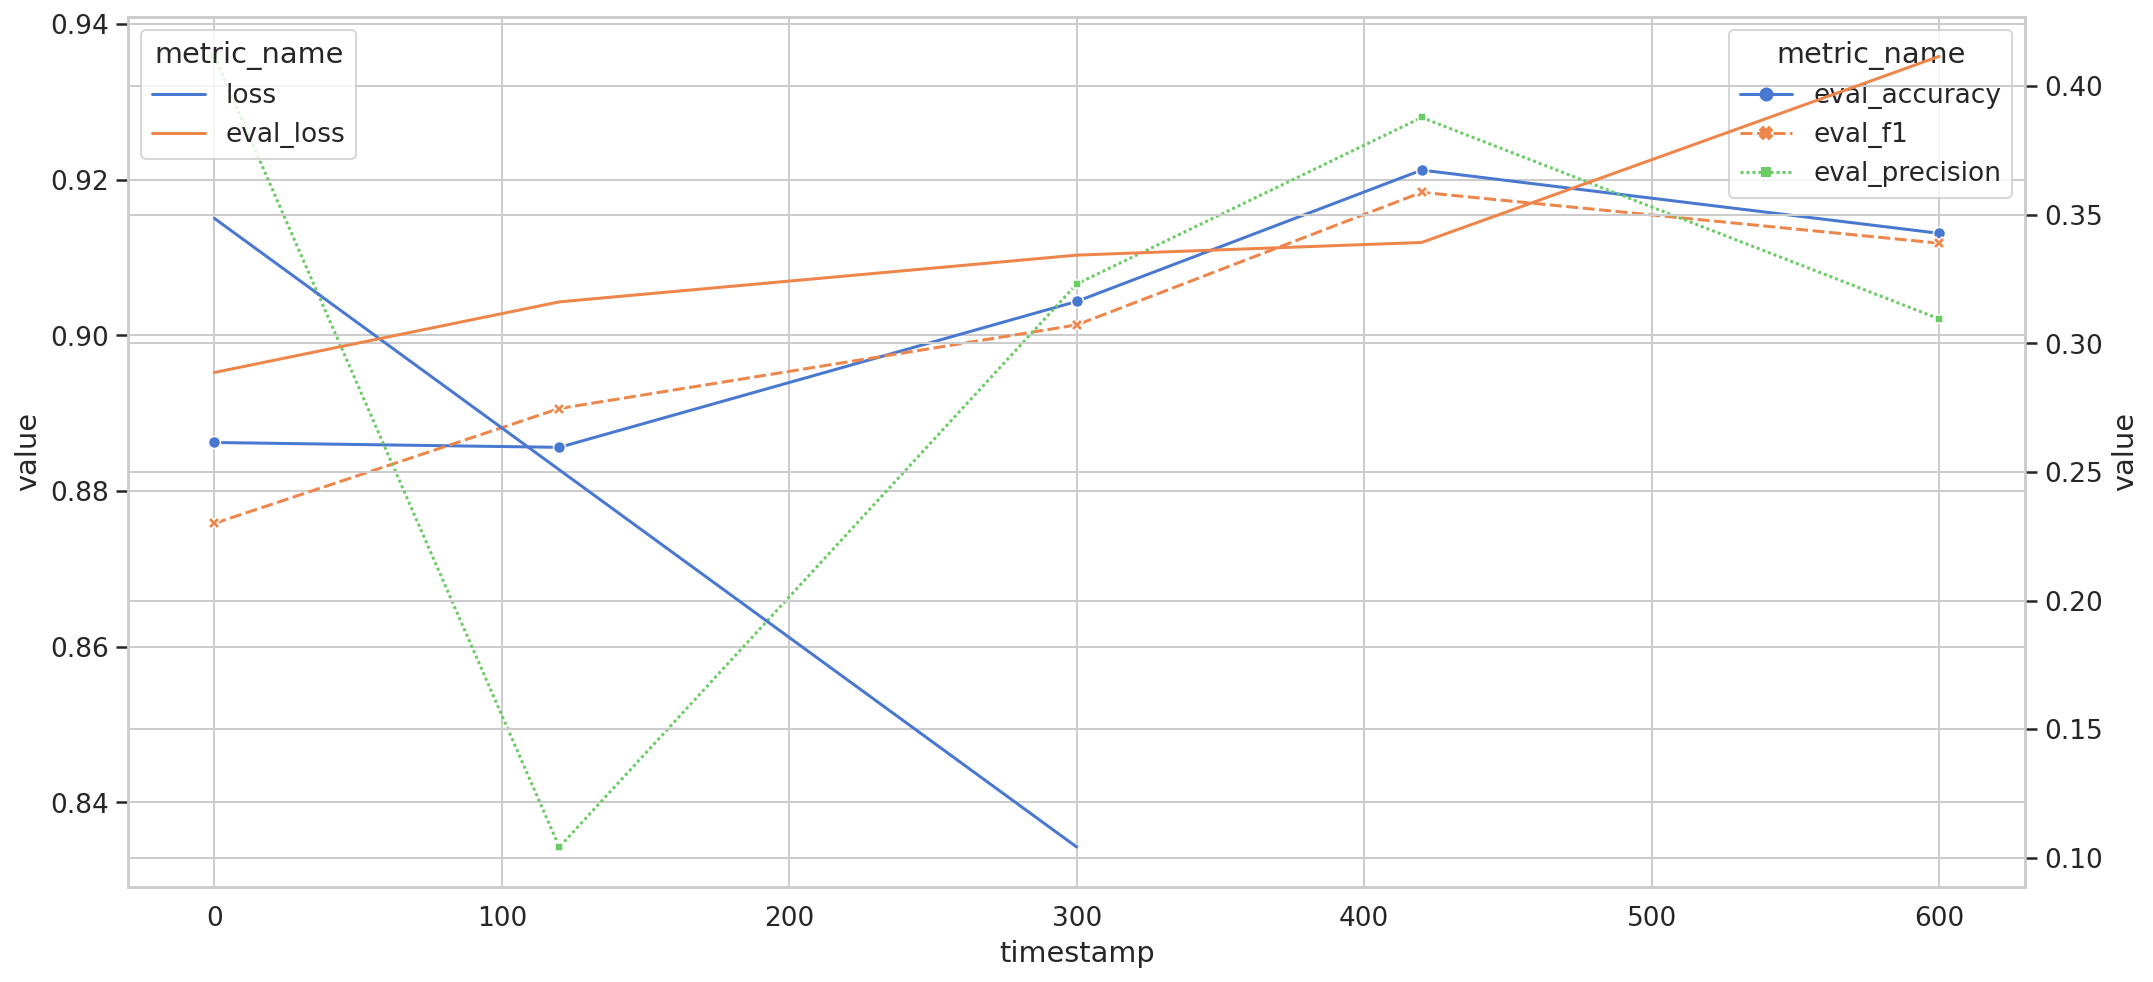

In [36]:
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision', 'eval_f1'])]
losses = df[df.metric_name.isin(['loss', 'eval_loss'])]

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    style='metric_name',
    markers=True,
    hue='metric_name'
)

ax2 = plt.twinx()
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name',
    ax=ax2)

# Endpoint

The `transformers pipelines` API allows you to use the `pipelines` features. 
Your inputs need to be defined in the `inputs` key.
If you want additional supported `pipelines` parameters you can add them in the `parameters` key.
The API is oriented at the API of the [🤗  Accelerated Inference API](https://api-inference.huggingface.co/docs/python/html/detailed_parameters.html), meaning your inputs need to be defined in the `inputs` key and if you want additional supported `pipelines` parameters you can add them in the `parameters` key. 

Below are a few request examples:

**text-classification request body**

```python
{
    "inputs": "Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days."
}
```

**question-answering request body**

```python
{
    "inputs": {
        "question": "What is used for inference?",
        "context": "My Name is Philipp and I live in Nuremberg. This model is used with sagemaker for inference."
    }
}
```

**zero-shot classification request body**

```python
{
    "inputs": "Hi, I recently bought a device from your company but it is not working as advertised and I would like to get reimbursed!\",
    "parameters": {
        "candidate_labels": [
            "refund",
            "legal",
            "faq"
         ]
    }
}
```

You can now proceed and create an endpoint with the trained model.

In [37]:
predictor = huggingface_estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

-------------!

After the endpoint is deployed you can run a prediction.

In [38]:
data = {
   "inputs": "Good product!"
}

# request
predictor.predict(data)

[{'label': 'LABEL_1', 'score': 0.9985395669937134}]

## Cleanup
After you are finished experimenting with this notebook, run the following cell to delete the predictor.

In [39]:
predictor.delete_endpoint()